# Singular Value Decomposition (특이치 분해)
<!-- 9-2 -->


사용 패키지의 로드
- numpy: 행렬 및 선형대수 관련 연산 수행
- matplotlib, matplotlib.pyplot: 시각화 도구
- sklearn.preprocessing.StandardScaler: 데이터 표준화 함수
- sklearn.decomposition.PCA: 주성분분석 도구

 cf) matplotlib.rcParams: 시각화 실행시 설정 변수 (runtime configuration parameter) 변수로 값을 변경함으로써 폰트, 색상등을 조절할 수 있습니다.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

먼저 이차원 벡터 $v_1 = (v_{11}, \cdots, v_{1p})$, $v_2 = (v_{21}, \cdots, v_{2p})$를 만들어보자. 

In [26]:
# --------------- 9-2 SVD --------------- #
### 9-2-1 내적과 각도, 정사영
np.random.seed(0)
p = 2
v1 = np.random.normal(size = p)
v2 = np.random.uniform(size = p)

이 두 벡터를 이용하여 벡터의 연산에 대해서 알아본다. 
- elementwise product
$$ v_1 \circ v_2 = (v_{11}v_{21}, \cdots, v_{1p}v_{2p}) $$
- ($l_2$-)norm
$$\|v_1\| = \sqrt{v_{11}^2 + \cdots v_{1p}^2}$$
- inner product
$$\langle v_1, v_2 \rangle  = v_{11}v_{21} + \cdots + v_{1p}v_{2p}$$
cf)  $\langle v_1, v_2 \rangle =v_1^\top v_2$

In [ ]:
# elementwise product
v1 * v2

In [7]:
# norm
np.sqrt(np.sum(v1 * v1))
np.linalg.norm(v1)

def vec_norm(vec):
    output = np.linalg.norm(vec)
    return output

vec_norm(v1)

1.8088688373462207

In [8]:
# inner product
np.sum(v1 * v2)
np.dot(v1.T, v2)

1.2813450810168578

In [9]:
# innter product를 이용하여 벡터의 norm 계산
np.sqrt(np.dot(v1.T, v1))

1.8088688373462207

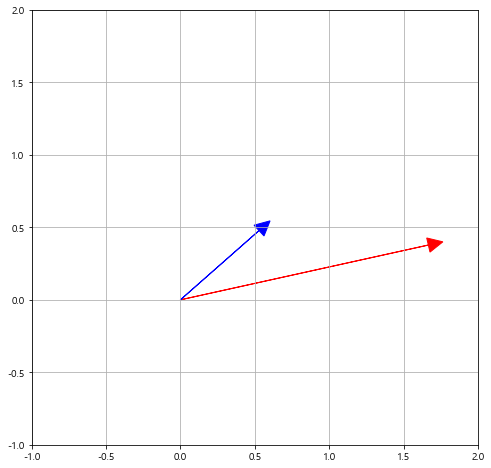

In [10]:
# 두 개의 벡터 그려보기
plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, v1[0], v1[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, v2[0], v2[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid()
plt.show()
plt.close()

두 벡터의 유사도는 벡터 차의 길이 (Euclidean distance와 같음), 코사인 유사도를 널리 이용합니다. 코사인 유사도는 각 벡터 길이에 의존하지 않는다는 특징이 있습니다. 여기서는 코사인 유사도를 구해보겠습니다.
$$sim(v_1,v_2) = \frac{\langle v_1, v_2 \rangle}{\|v_1\|\|v_2\|}$$

cf) Cauchy-Schwartz 부등식으로 
\begin{align}
|v_1^\top v_2| \leq \|v_1\|\|v_2\|
\end{align}
이므로 
$$-1 \leq sim(v_1,v_2)\leq 1$$
를 알 수 있다.

In [12]:
# 코사인 유사도
def cosine_similarity(vec1, vec2):
    cosim = np.dot(vec1, vec2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return cosim

In [13]:
cosine_similarity(v1, v2)

0.8717947315508269

v2의 v1위로 정사영(projection)은 다음과 같이 표시합니다.
$$\prod_{\mathcal{C}(v_1)}v_2$$
여기서 $\prod_{\mathcal{C}(v_1)}$는 $v_1$이 생성하는 공간으로 정사영을 만들어주는 행렬(선형변환)이며 $v_2$는 이 선형변환에 대한 입력변수로 간주하면 됩니다. 즉, $v_2$을 $v_1$이 생성하는 공간으로 정사영한 결과가 $\prod_{\mathcal{C}(v_1)}v_2$입니다.


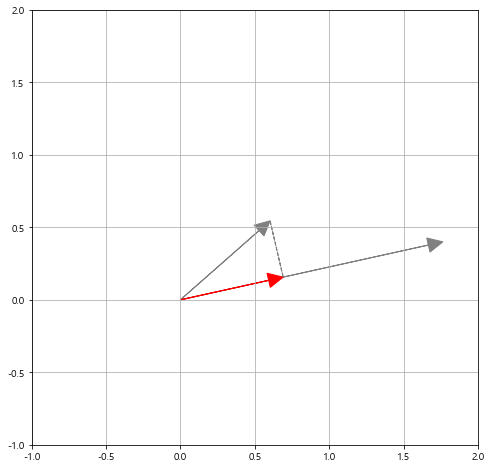

In [30]:
# 정사영
# v2의 v1위로 정사영
def projection(vec1, vec2):
    proj = (np.dot(vec1, vec2) / vec_norm(vec1)) * (vec1 / vec_norm(vec1))
    return proj

proj_vec = projection(v1, v2)

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, v1[0], v1[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, v2[0], v2[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0, 0, proj_vec[0], proj_vec[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(proj_vec[0], proj_vec[1], v2[0]-proj_vec[0], v2[1]-proj_vec[1], head_width = 0, head_length = 0, length_includes_head = True, color = 'gray', linestyle = 'dashed')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid()
plt.show()
plt.close()

In [15]:

### 9-2-2 선형변환으로서 직교행렬과 대각행렬
seed = 0
np.random.seed(seed)
n = 2
mat = np.random.normal(size = (n, n))

In [16]:
# 대각행렬
diag_mat1 = np.identity(n)
trans_mat1 = mat @ diag_mat1
print(f'original matrix: \n{mat} \ntransformed matrix:\n{trans_mat1}')

original matrix: 
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] 
transformed matrix:
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]


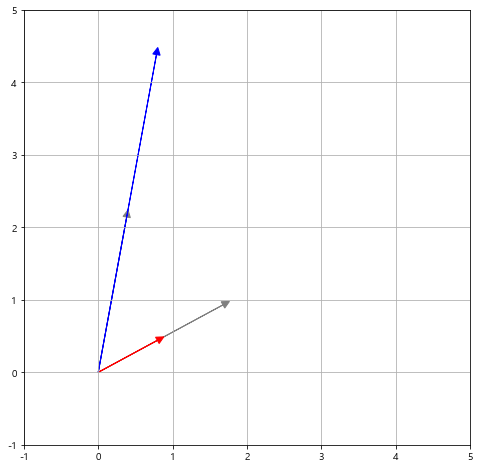

original matrix: 
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] 
transformed matrix:
[[0.88202617 0.80031442]
 [0.48936899 4.4817864 ]]


In [17]:
diag_elem = [0.5, 2]
diag_mat2 = diag_elem * np.identity(n)
trans_mat2 = mat @ diag_mat2

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat[:, 0][0], mat[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, mat[:, 1][0], mat[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, trans_mat2[:, 0][0], trans_mat2[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat2[:, 1][0], trans_mat2[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat} \ntransformed matrix:\n{trans_mat2}')

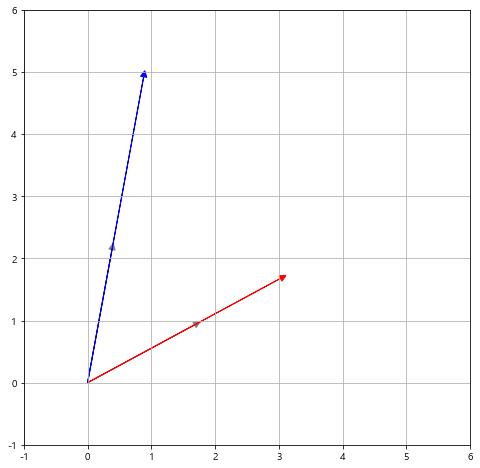

original matrix: 
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] 
transformed matrix:
[[3.11188068 0.89670957]
 [1.72654504 5.02160233]]


In [18]:
diag_elem = np.diag(mat)
diag_mat3 = diag_elem * np.identity(n)
trans_mat3 = mat @ diag_mat3

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat[:, 0][0], mat[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, mat[:, 1][0], mat[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, trans_mat3[:, 0][0], trans_mat3[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat3[:, 1][0], trans_mat3[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat} \ntransformed matrix:\n{trans_mat3}')

In [22]:
# 직교행렬
mat2 = np.array([1, 2, 3, 5]).reshape(2, 2)
q, r = np.linalg.qr(mat2)
print("Q matrix:\n", q)
print("R matrix:\n", r)
print("Q is orthogonal matrix:\n", q @ q.T)

Q matrix:
 [[-0.31622777 -0.9486833 ]
 [-0.9486833   0.31622777]]
R matrix:
 [[-3.16227766 -5.37587202]
 [ 0.         -0.31622777]]
Q is orthogonal matrix:
 [[ 1.00000000e+00 -5.84964249e-17]
 [-5.84964249e-17  1.00000000e+00]]


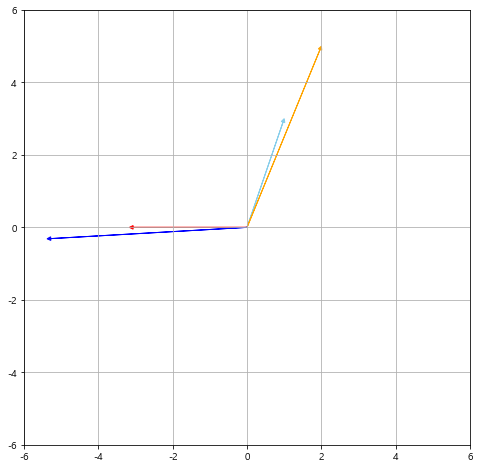

original matrix: 
[[1 2]
 [3 5]] 
transformed matrix:
[[-3.16227766e+00 -5.37587202e+00]
 [ 3.88578059e-16 -3.16227766e-01]]


In [23]:
trans_mat4 = q @ mat2

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat2[:, 0][0], mat2[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'skyblue')
plt.arrow(0 ,0, mat2[:, 1][0], mat2[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'orange')
plt.arrow(0 ,0, trans_mat4[:, 0][0], trans_mat4[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat4[:, 1][0], trans_mat4[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat2} \ntransformed matrix:\n{trans_mat4}')

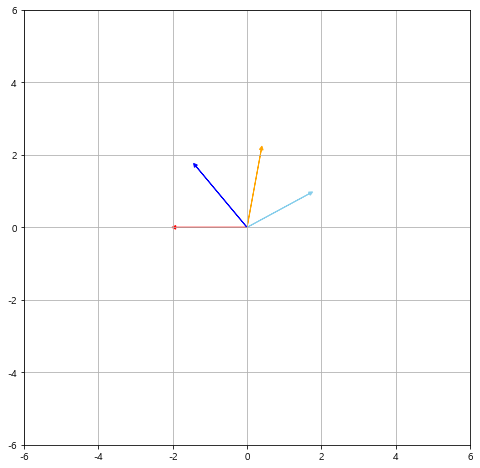

original matrix: 
[[1 2]
 [3 5]] 
transformed matrix:
[[-3.16227766e+00 -5.37587202e+00]
 [ 3.88578059e-16 -3.16227766e-01]]


In [24]:
q, r = np.linalg.qr(mat)
q @ q.T

trans_mat5 = q @ mat
# trans_mat5 = q.T @ mat @ q

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat[:, 0][0], mat[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'skyblue')
plt.arrow(0 ,0, mat[:, 1][0], mat[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'orange')
plt.arrow(0 ,0, trans_mat5[:, 0][0], trans_mat5[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat5[:, 1][0], trans_mat5[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat2} \ntransformed matrix:\n{trans_mat4}')

In [ ]:


### 9-2-3 행렬의 특이치 분해
n = 10
p = 2

seed = 0
np.random.seed(seed)

x = np.random.normal(size = (n, p))
u, s, vh= np.linalg.svd(x, full_matrices=False)
u.shape
s.shape
vh.shape

# UDV^T 에서 V^T matrix를 확인
# V행렬의 열벡터는 직교함
(vh[0,:]*vh[1,:]).sum()

# 0번 obs의 표현형
u[0,:]

# scaled
plt.plot(u[:,0],u[:,1], '.')

# considering the size s
plt.plot(s[0]*u[:,0],s[1]*u[:,1], '.')

# approximation
k = 1
x_approx = u[:,:k]@np.diag(s[:k])@vh[:k,:]
print( np.mean((x-x_approx)**2) )

# 주성분 값을 이용한 데이터의 재표현
x
u@np.diag(s)@vh

# x^T
x.T
vh.T@(np.diag(s)).T@u.T

#
x.T@x
vh.T@(np.diag(s)).T@u.T@u@(np.diag(s))@vh

# covariance
(x - np.mean(x, axis = 0)).T@(x - np.mean(x, axis = 0))/x.shape[0]
covmat = np.cov(x, rowvar = False, bias = True)
covmat

centered_x = np.zeros_like(x)
for i in range(x.shape[1]):
    centered_x[:, i] = x[:, i] - np.mean(x[:, i])

u, s, vh= np.linalg.svd(centered_x, full_matrices=False)
vh.T@(np.diag(s)).T@u.T@u@(np.diag(s))@vh
covmat

